###### K-means Clustering and Principal Component Analysis

1. Implement the K-means clustering algorithm and apply it to compress an image

2. Use principal component analysis to find a low-dimensional representation of face images

In [1]:
import numpy  as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy
import scipy.optimize as opt
import scipy.io as sio
from scipy.io import loadmat

# K-means Clustering

Implement K-means algorithm and use it for `Image compression`
1. start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works
2. use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image

## Implementing K-means

The K-means algorithm is a method to automatically `cluster similar data examples together`. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”.

The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

+ The inner-loop of the algorithm repeatedly carries out two steps: 
+ (1) Assigning each training example $x^{(i)}$ to its closest centroid
+ (2) Recomputing the mean of each centroid using the points assigned to it.

The K-means algorithm will always converge to some final set of means for the centroids. 

Note that the converged solution may not always be ideal and `depends on the initial setting of the centroids`. 

Therefore, in practice the K-means algorithm is usually `run a few times with different random initializations`. One way to choose between these different solutions from different random initializations is to `choose the one with the lowest cost function value` (distortion).

### Finding closest centroids

`Cluster Assignment` : the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids.

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid. Note that $c^{(i)}$ corresponds to `idx[i]` in the starter code.

###### load data

In [2]:
path = "dataset/ex7data2.mat"
ori_data = sio.loadmat(path)

X = ori_data['X']
print('X :', X.shape)

X : (300, 2)


> + X         : (m * n)
> + centroids : (k * n)
> + c_current : (m * k)
> + return : (m, )

In [3]:
def find_closet_centroid(X, centroids):
    c_distance = np.zeros((X.shape[0], centroids.shape[0]))
    
    c_current = np.zeros((centroids.shape[0], X.shape[0], X.shape[1]))

    for i in np.arange(len(centroids)):
        c_current[i] = np.ones_like(X) * centroids[i]
        c_distance[:,i] = np.power(np.linalg.norm(X - c_current[i], axis=1), 2)
    
    idx = np.argmin(c_distance, axis=1)
    
    return idx

In [4]:
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
centroid_idx = find_closet_centroid(X, initial_centroids)
print("First three examples's new centroid :", centroid_idx[:3])

First three examples's new centroid : [0 2 1]


run your code and you should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples

### Computing centroid means

Re-compute the new centroid of each classes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$.

In [5]:
def compute_centroid(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    # In loop, we may countor the situation which no example assigned to centroid K
    for i in np.arange(K):
        samples = X[idx == i]     # choose centroid-i by one time
        if len(samples) != 0:
            centroids[i] = np.mean(samples, axis=0)
    
    return centroids

In [6]:
K = 3
new_centroid = compute_centroid(X, centroid_idx, K)

## K-means on example dataset

Run the K-means algorithm on a toy 2D dataset to help you understand how K-means works.

When you run the next step, the K-means code will produce an animation that steps you through the progress of the algorithm at each iteration. At the end, your figure should look as the one displayed below.

![](Figures/kmeans_result.png)

In [7]:
centroid_history = []
idx_history = []

In [8]:
def kmeans_algorithm(X, centroids, max_iters):
    global centroid_history, idx_history
    idx_history = []
    centroid_history = []
    K = centroids.shape[0]
    idx = None

    for i in range(max_iters):
        idx = find_closet_centroid(X, centroids)
        idx_history.append(idx)
        centroid_history.append(centroids)
        centroids = compute_centroid(X, idx, K)

    return centroids, idx

In [9]:
path = "dataset/ex7data2.mat"
data = sio.loadmat(path)
X = data['X']

K = 3
max_iters = 100
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
centroids, idx = kmeans_algorithm(X, initial_centroids, max_iters)

In [10]:
centroid_history = np.array(centroid_history)
print("centroid_history", centroid_history.shape)

idx_history = np.array(idx_history)
print("idx_history", idx_history.shape)

centroid_history (100, 3, 2)
idx_history (100, 300)


In [11]:
def plot_progress_kMeans(X, centroid_history, idx_history, axes=None):    
    if axes == None:
        axes = plt.gca()
    
    K = centroid_history[0].shape[0]

    cmap = plt.cm.rainbow
    norm = mpl.colors.Normalize(vmin=0, vmax=K*5)

    for i in np.arange(K):
        data = X[idx_history[-1] == i]
        axes.scatter(data[:, 0], data[:, 1], cmap=cmap, marker='o',
                    s=18, linewidths=1)

    gap = 0
    for k in np.arange(K):
        show_max = 10
        axes.plot(centroid_history[:show_max,k,0], centroid_history[:show_max,k,1],
                 '-Xk', mec='k', lw=1, ms=18, mfc=cmap(norm(k*5+gap)), mew=0.5)
        axes.scatter(centroid_history[-1,k,0], centroid_history[-1,k,1],
                    marker='+', s=33**2, lw=5)
        
        gap = gap - 0.01

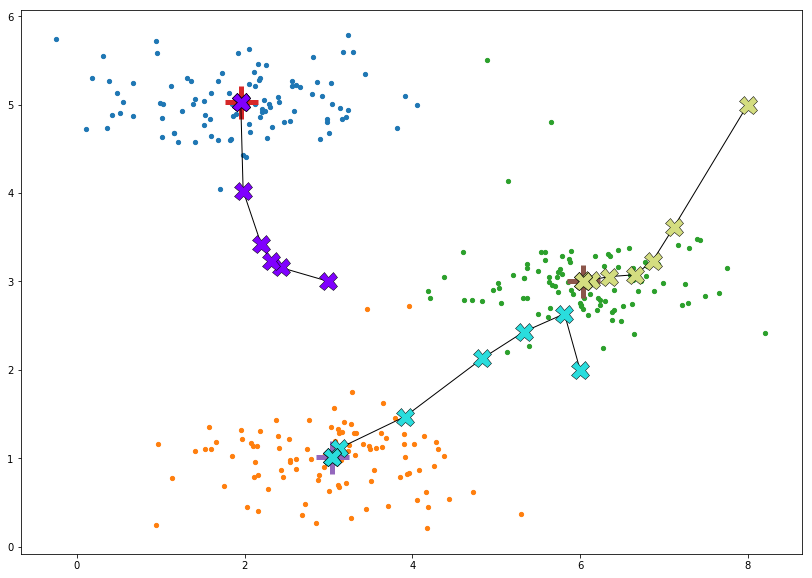

In [12]:
centroid_history = np.array(centroid_history)
idx_history = np.array(idx_history)
plt.figure(figsize=(14,10))
plot_progress_kMeans(X, centroid_history, idx_history, axes=plt.gca())

## Random initialization

In practice, a good strategy for initializing the centroids is to select random examples from the training set.

In [13]:
def random_init_centroid(X, K):
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    # Take the first K examples as centroids
    centroids = X[randidx[:K],:]
    
    return centroids

In [14]:
def run_kmeans_with_random_init(X, K, axes=None):
    global centroid_history, idx_history
    rand_init_centroids = random_init_centroid(X, K)
    centroids, idx = kmeans_algorithm(X, rand_init_centroids, max_iters)
    centroid_history = np.array(centroid_history)
    idx_history = np.array(idx_history)
    plot_progress_kMeans(X, centroid_history, idx_history, axes)

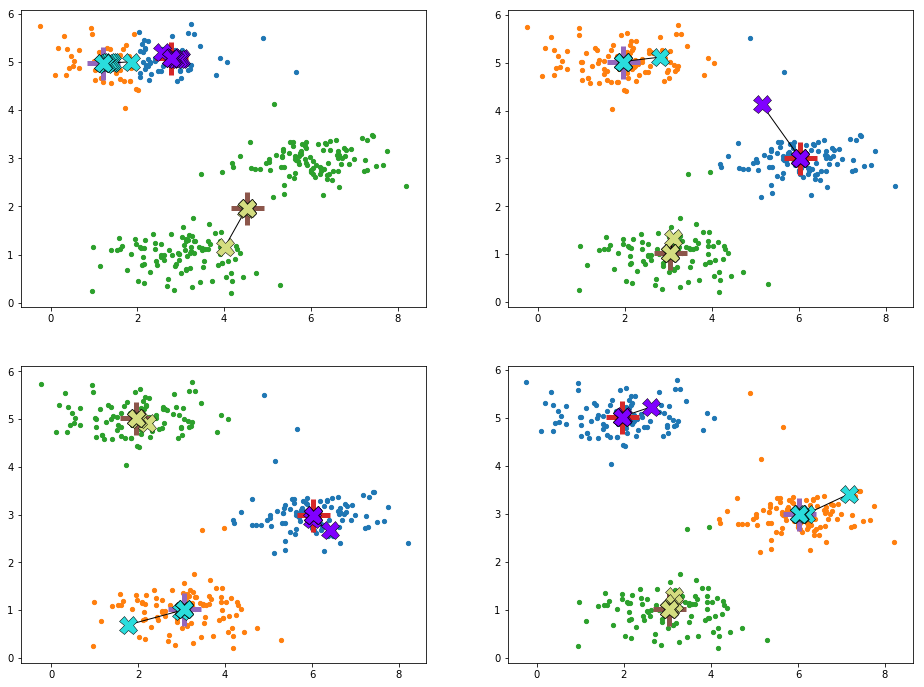

In [15]:
fig, axes = plt.subplots(2, 2, figsize=((16, 12)))
K = 3
for i in range(4):
    axes_i = axes.flatten()[i]
    run_kmeans_with_random_init(X, K, axes_i)

## Image compression with K-means

`Apply K-means to image compression`.

![](Data/bird_small.png)

In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

### K-means on pixels

Finally, you can view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, you can replace each pixel location with the mean of the centroid assigned to it. The figure below shows the reconstruction we obtained. 

![](Figures/bird_compression.png)

Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts.

In [16]:
img = mpl.image.imread('dataset/bird_small.png')
print('img.shape :', img.shape)

img.shape : (128, 128, 3)


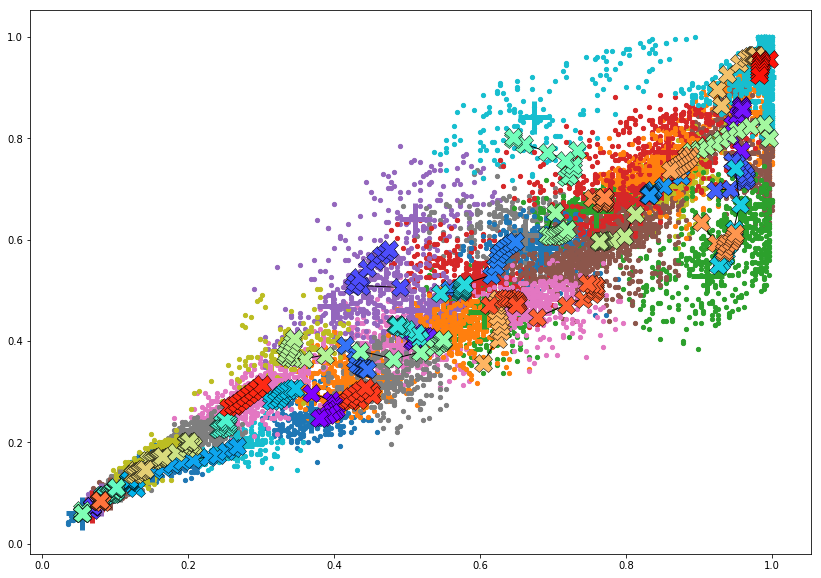

In [17]:
K = 40
max_iters = 50

img = mpl.image.imread('dataset/bird_small.png')
IMG = img.reshape(-1, 3)

rand_init_centroids = random_init_centroid(IMG, K)
centroids, idx = kmeans_algorithm(IMG, rand_init_centroids, max_iters)
centroid_history = np.array(centroid_history)
idx_history = np.array(idx_history)
plt.figure(figsize=(14,10))
plot_progress_kMeans(IMG, centroid_history, idx_history, plt.gca())

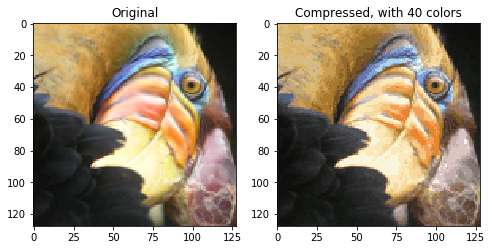

In [18]:
X_recovered = centroids[idx, :].reshape(img.shape)
# Display the original image, rescale back by 255
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed , rescale back by 255
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

In [19]:
self_picture_dict = ['pic_01', 'pic_02', 'pic_03', 'pic_04', 'pic_05', 'pic_06']

In [20]:
Play = False
if Play == True:
    img = mpl.image.imread('dataset/pic_01.png')
    K = 20
    max_iters = 50

    IMG = img.reshape(-1, 3)

    rand_init_centroids = random_init_centroid(IMG, K)
    #print(rand_init_centroids)
    centroids, idx = kmeans_algorithm(IMG, rand_init_centroids, max_iters)
    centroid_history = np.array(centroid_history)
    idx_history = np.array(idx_history)
    plot_progress_kMeans(IMG, centroid_history, idx_history)

In [21]:
if Play == True:
    X_recovered = centroids[idx, :].reshape(img.shape)
    # Display the original image, rescale back by 255
    fig, ax = plt.subplots(2, 1, figsize=(40, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original')
    ax[0].grid(False)

    # Display compressed , rescale back by 255
    ax[1].imshow(X_recovered)
    ax[1].set_title('Compressed, with %d colors' % K)
    ax[1].grid(False)

# Principal Component Analysis

`Use principal component analysis (PCA) to perform dimensionality reduction`.

###### >>> Reduce the data from 2D to 1D

In this part of the exercise, you will visualize what happens when you use PCA to reduce the data from 2D to 1D. In practice, you might want to reduce data from 256 to 50 dimensions, say; but using lower dimensional data in this example allows us to visualize the algorithms better.

In [22]:
path = "dataset/ex7data1.mat"
data = sio.loadmat(path)

X = data['X']

In [23]:
def plot_ori_data(data, axes=None):
    if axes == None:
        axes = plt.gca()
    
    axes.scatter(data[:, 0], data[:, 1],
                 marker='o', s=18, lw=1)

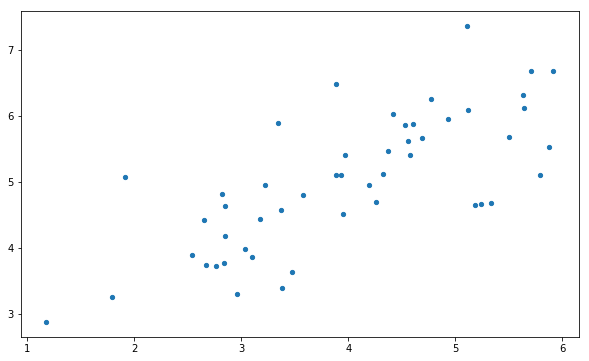

In [24]:
plt.figure(figsize=(10, 6))
plot_ori_data(X, plt.gca())

## Implementing PCA

PCA consists of two computational steps: 
1. Compute the `covariance matrix` of the data.
2. Use SVD to compute the `eigenvectors` $U_1$, $U_2$, $\dots$, $U_n$. These will correspond to `the principal components of variation in the data`.

`Compute the covariance matrix of the data`

$$ \Sigma = \frac{1}{m} X^T X$$

> + where $X$ is the data matrix with examples in rows, and $m$ is the number of examples.
> + Note that $\Sigma$ is a $n \times n$ matrix and not the summation operator. 

Run SVD on it to `compute the principal components` ----- `U, S, V = np.linalg.svd(Sigma)`
> + `U` will contain the principal components
> + `S` will contain a diagonal matrix

### SVD method

In [25]:
def SVD_(data):
    cov = np.cov(data.T)
    u, s, v = np.linalg.svd(cov)
    # scipy.linalg.svd
    
    return u, s, v

In [26]:
U, S, V = SVD_(X)

### normalize data

`Before using PCA`, it is important to first `normalize the data` by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

In [27]:
mu = 0
std = 0

def feature_normalization(X):
    global mu, std
    
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    X_norm = (X - mu) / std
    
    return X_norm
    
X_norm = feature_normalization(X)

In [28]:
from sklearn import preprocessing
X_norm = preprocessing.scale(X)

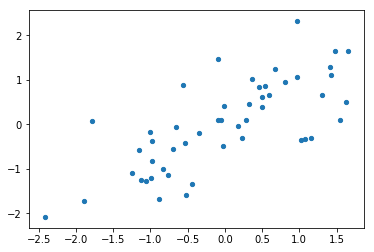

In [29]:
plot_ori_data(X_norm)

After normalizing the data, you can `run PCA to compute the principal components`.

In [30]:
X_norm = preprocessing.scale(X)
U, S, V = SVD_(X_norm)

### plot principal component

run PCA on the example dataset and `plot the corresponding principal components` found similar to the figure below. 

![](Figures/pca_components.png)


The following cell will also output the top principal component (eigenvector) found, and you should expect to see an output of about `[-0.707 -0.707]`. (It is possible that `numpy` may instead output the negative of this, since $U_1$ and $-U_1$ are equally valid choices for the first principal component.)

Top eigenvector: U[:, 0] = [-0.707107 -0.707107]
 (you should expect to see [-0.707107 -0.707107])


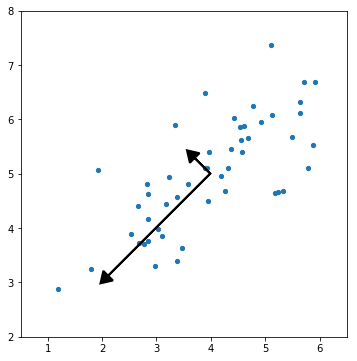

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_ori_data(X, axes=ax)

for i in range(2):
    ax.arrow(mu[0], mu[1], 1.5 * S[i]*U[0, i], 1.5 * S[i]*U[1, i],
             head_width=0.25, head_length=0.2, fc='k', ec='k', lw=2, zorder=1000)

ax.axis([0.5, 6.5, 2, 8])
ax.set_aspect('equal')
ax.grid(False)

print('Top eigenvector: U[:, 0] = [{:.6f} {:.6f}]'.format(U[0, 0], U[1, 0]))
print(' (you should expect to see [-0.707107 -0.707107])')

## `Dimensionality Reduction` with PCA

After `computing the principal components`, you can use them to `reduce the feature dimension` of your dataset by `projecting each example onto a lower dimensional space`, $x^{(i)} \rightarrow z^{(i)}$ (e.g., projecting the data from 2D to 1D). 

In this part of the exercise, you will use the eigenvectors returned by PCA and `project the example dataset into a 1-dimensional space`. 

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input.

### Projecting the data onto the principal components

Specifically, you are given a dataset `X`, the principal components `U`, and the desired number of dimensions to reduce to `K`.

You should project each example in `X` onto the top `K` components in `U`.

Note that the top `K` components in `U` are given by the first `K` columns of `U`, that is `Ureduce = U[:, :K]`.

In [32]:
def project_data(X_norm, U, K):
    U_reduce = U[:,:K].reshape((-1,K))
    Z = U_reduce.T @ X_norm.T
    
    return Z.T

In [33]:
K = 1
Z = project_data(X_norm, U, K)
print("New 1-dim feature:\n", Z[:5])

New 1-dim feature:
 [[ 1.49631261]
 [-0.92218067]
 [ 1.22439232]
 [ 1.64386173]
 [ 1.2732206 ]]


### Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space.

In [34]:
def recover_data(Z, U, K):
    U_reduce = U[:,:K].reshape((-1,K))
    X_approx = U_reduce @ Z.T
    
    return X_approx.T

In [35]:
X_rec = recover_data(Z, U, K)
print("X_rec[:1] : \n", X_rec[:1])

X_rec[:1] : 
 [[-1.05805279 -1.05805279]]


### plot reconstructing data

plot the data in this reduced dimension space

![](Figures/pca_reconstruction.png)

> + The dotted lines show the distance from the data points in original space to the projected space.
> + Those dotted lines represent the error measure due to PCA projection.

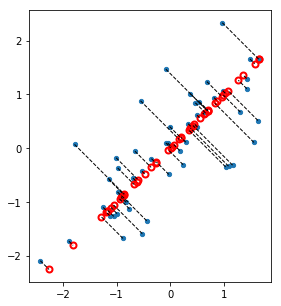

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_ori_data(X_norm, axes=ax)

ax.set_aspect('equal')
ax.grid(False)

# Draw lines connecting the projected points to the original points
ax.plot(X_rec[:, 0], X_rec[:, 1], 'ro', mec='r', mew=2, mfc='none')
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

## Face Image Dataset

Run `PCA` on `face images` to see how it can be used in `practice for dimension reduction`.

The dataset `ex7faces.mat` contains a dataset `X` of face images, each $32 \times 32$ in grayscale. Each row of `X` corresponds to one face image (a row vector of length 1024).

In [37]:
path = "dataset/ex7faces.mat"
data = sio.loadmat(path)
X = data['X']

In [38]:
def visualize_data(X):
    img_size = int(np.sqrt(X.shape[1]))
    
    sample_img = X[:100, :]
    sample_img = np.array([im.reshape((img_size, img_size)).T for im in sample_img])
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12, 12))
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_img[10 * r + c].reshape((img_size, img_size)),
                                   cmap='gray') # Greys_r
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

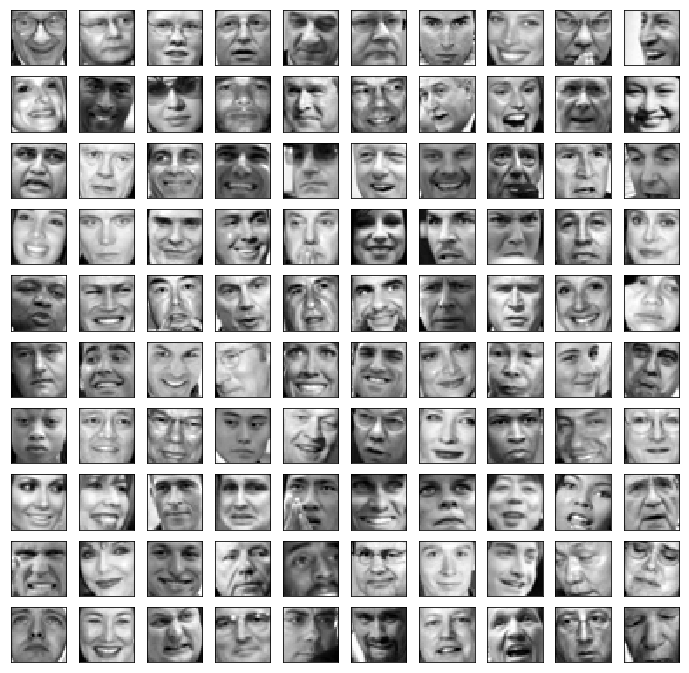

In [39]:
visualize_data(X)

### PCA on Faces

1. To run PCA on the face dataset, we `first normalize the dataset` by subtracting the mean of each feature from the data matrix `X`.
2. After running PCA, you will obtain the principal components of the dataset. Notice that each principal component in `U` (each column) is a vector of length $n$ (where for the face dataset, $n = 1024$). It turns out that we can visualize these principal components by reshaping each of them into a $32 \times 32$ matrix that corresponds to the pixels in the original dataset.

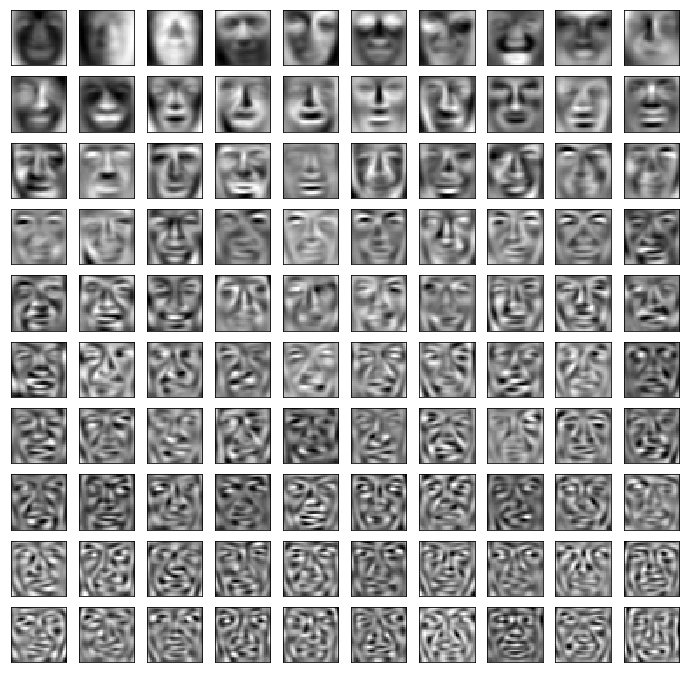

In [40]:
X_norm = preprocessing.scale(X)
U, S, V = SVD_(X_norm)
visualize_data(U[:,:100].T)

In [41]:
U[:10]

array([[-0.01425307, -0.03606596, -0.04561884, ...,  0.00521903,
         0.00091143,  0.00077515],
       [-0.01474233, -0.03809858, -0.04756249, ..., -0.01142763,
        -0.00228691, -0.00434598],
       [-0.01501482, -0.03988747, -0.05082085, ...,  0.01843345,
         0.00554132,  0.00873415],
       ...,
       [-0.01638289, -0.04787533, -0.05767023, ..., -0.00026142,
         0.00134701, -0.00019656],
       [-0.01655796, -0.04851286, -0.05746905, ..., -0.00180985,
        -0.00076796,  0.00163865],
       [-0.01676008, -0.0495214 , -0.05823576, ...,  0.00592823,
        -0.00133534, -0.00149098]])

### Dimensionality Reduction

Now that you have computed the `principal components` for the face dataset, you can use it to `reduce the dimension of the face dataset`. 

This allows you to `use your learning algorithm with a smaller input size` (e.g., 100 dimensions) instead of the original 1024 dimensions.

$z^{(i)} \in \mathbb{R}^{100}$

In [42]:
K = 100
Z = project_data(X_norm, U, K)
X_rec = recover_data(Z, U, K)

print("Project_data :", Z.shape)
print("Reconstruct_data :", X_rec.shape)

Project_data : (5000, 100)
Reconstruct_data : (5000, 1024)


This is a remarkable reduction (more than 10x) in the dataset size that can help speed up your learning algorithm significantly.

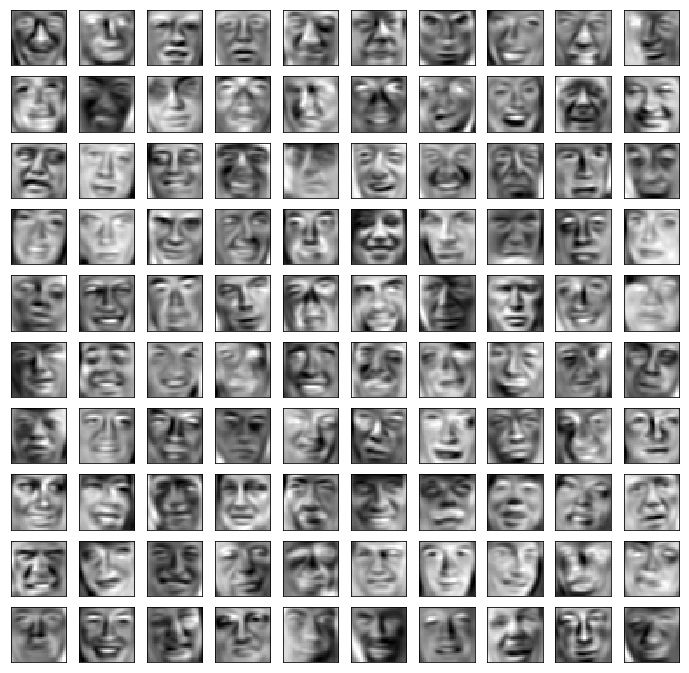

In [43]:
visualize_data(X_rec)

## PCA for visualization

In the earlier K-means image compression exercise, you used the K-means algorithm in the 3-dimensional RGB space. We reduced each pixel of the RGB image to be represented by 16 clusters.

In the next cell, we have provided code to visualize the final pixel assignments in this 3D space. Each data point is colored according to the cluster it has been assigned to. You can drag your mouse on the figure to rotate and inspect this data in 3 dimensions.

In [44]:
%matplotlib notebook
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

(16384, 3)


<IPython.core.display.Javascript object>


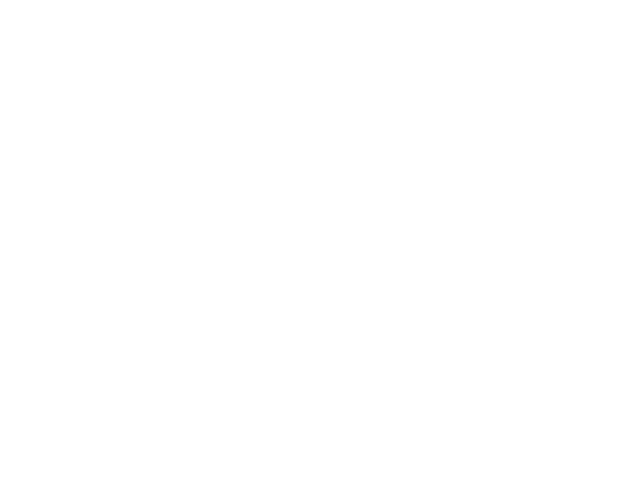

In [45]:
img = mpl.image.imread('dataset/bird_small.png')
K = 40
max_iters = 50

IMG = img.reshape(-1, 3)
print(IMG.shape)

rand_init_centroids = random_init_centroid(IMG, K)
#print(rand_init_centroids)
centroids, idx = kmeans_algorithm(IMG, rand_init_centroids, max_iters)
centroid_history = np.array(centroid_history)
idx_history = np.array(idx_history)
plot_progress_kMeans(IMG, centroid_history, idx_history)

<IPython.core.display.Javascript object>


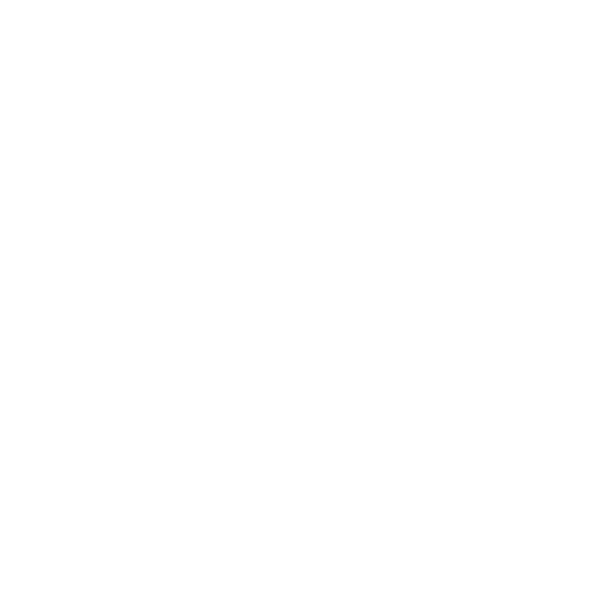

Text(0.5,0.92,'Pixel dataset plotted in 3D.\nColor shows centroid memberships')

In [46]:
#  Sample 1000 random indexes (since working with all the data is
#  too expensive. If you have a fast computer, you may increase this.
sel = np.random.choice(IMG.shape[0], size=1000)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(IMG[sel, 0], IMG[sel, 1], IMG[sel, 2], cmap='rainbow', c=idx[sel], s=8)
ax.set_title('Pixel dataset plotted in 3D.\nColor shows centroid memberships')

In practice, PCA is often used to reduce the dimensionality of data for `visualization` purposes. 

In [47]:
X_norm = preprocessing.scale(IMG)
U, S, V = SVD_(X_norm)

/home/local/SPREADTRUM/xing.jian/Public/Soft/Anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/local/SPREADTRUM/xing.jian/Public/Soft/Anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [48]:
K = 2
Z = project_data(X_norm, U, K)

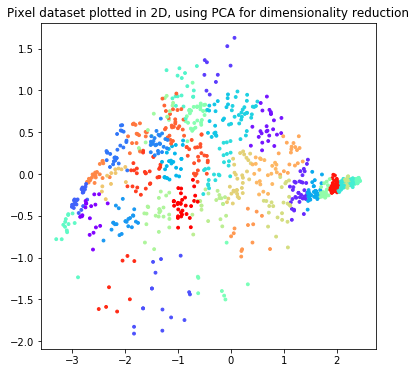

In [49]:
# Reset matplotlib to non-interactive
%matplotlib inline

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.scatter(Z[sel, 0], Z[sel, 1], cmap='rainbow', c=idx[sel], s=8)
ax.set_title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')
ax.grid(False)